# Программирование и компьютерные науки

## Семинар 8

На прошлом занятии мы познакомились с таким мощным способом построения композиций, как градиентный бустинг. Напомним принципы его работы.

Пусть дана обучающая выборка $X = \{(x_i, y_i)\}_{i=1}^l$ и выбран функционал качества $Q(a, X) = \sum_{i=1}^l L(y_i, a(x_i)),$ который мы стремимся минимизировать. Градиентный бустинг строит композиции вида $a_N(x) = \sum_{n=0}^N \gamma_n b_n(x),$ где $b_n \in \mathcal{B}$ — базовые алгоритмы из некоторого параметрического семейства $\mathcal{B}$.

Композиция строится пошагово, на $n$-ом шаге к композиции добавляется алгоритм $b_n$ путём выполнения следующих действий:
 1. Вычисление сдвигов текущей композиции по выборке $X$: $$s_i^{(n)} = - \frac{\partial L}{\partial z} (y, z)\Bigg|_{z = a_{n-1}(x_i)}$$
 2. Обучение нового базового алгоритма на выборке $\{(x_i, s_i)\}_{i=1}^l$: $$b_n = \arg\min_{b \in \mathcal{B}} \sum_{i=1}^l (b_n(x_i) - s_i)^2$$
 3. Подбор коэффициента $\gamma_n$ при новом базовом алгоритме:
 $$\gamma_n = \arg \min_{\gamma} \sum_{i=1}^l L(y_i, a_{n-1}(x_i) + \gamma b_n(x_i))$$
 
Как обсуждалось ранее, при использовании градиентного бустинга можно понизить смещение моделей, но при этом разброс итоговой композиции останется таким же, как у отдельного базового алгоритма, или увеличится. Поэтому в качестве базовых алгоритмов удобно брать решающие деревья малой глубины, поскольку они обладают большим смещением и малым разбросом.

## Градиентный бустинг и бэггинг

Сравним, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

Напомним, что для построения композиции при помощи бэггинга из $X$ случайно и независимо выбираются подвыборки $\tilde{X}_n, n = 1, \dots, N.$ После этого на каждой из этих выборок обучается алгоритм из параметрического множества $\mathcal{B},$ в результате чего получаем алгоритмы $b_n(x), n = 1, \dots, N.$ Прогноз итоговой композиции строится следующим образом: 

$a(x) = \frac{1}{N} \sum_{n=1}^N b_n(x)$ (в случае регрессии),

$a(x) = \arg \max_{k = 1, \dots, K} \sum_{n=1}^N [b_n(x) = k]$ (в случае классификации на K классов).

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом $N$ это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

### Модельный пример

Продемонстрируем это сравнение на простом модельном примере.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

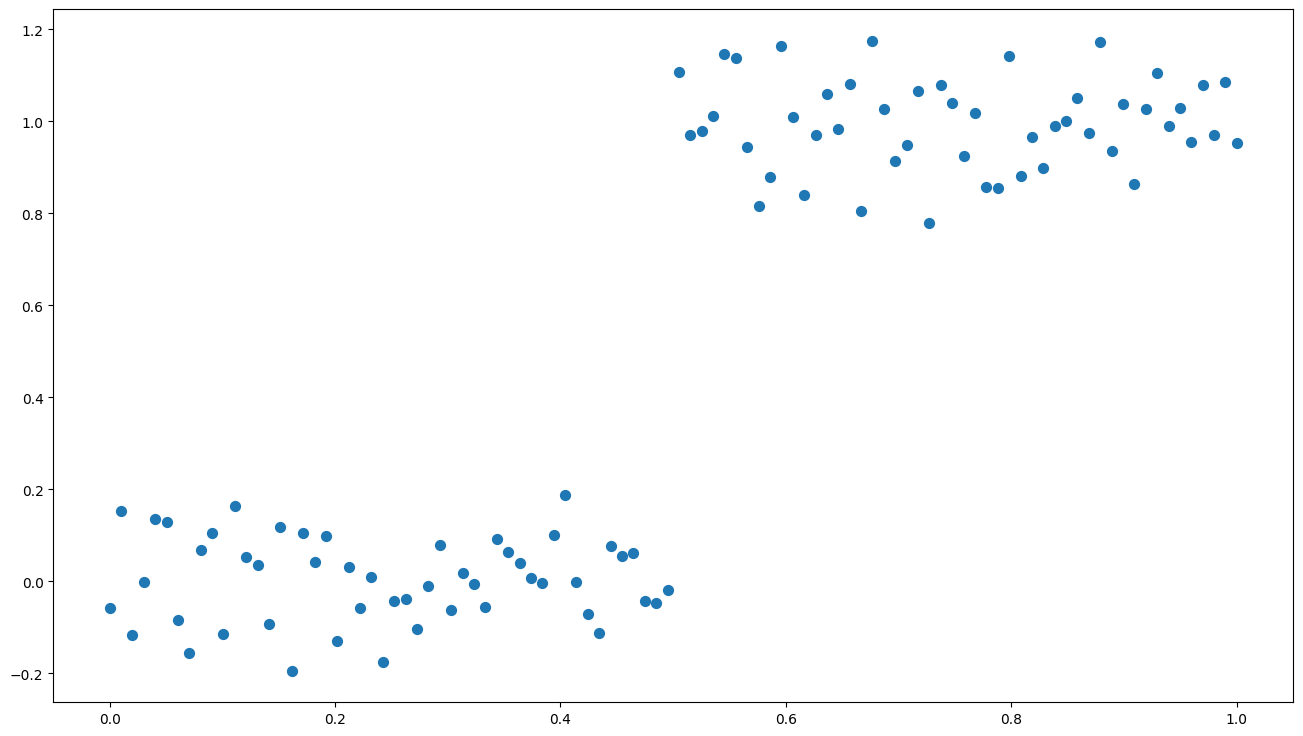

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

Обучим на нем большое количество решающих деревьев бэггингом. Для наглядности на графиках используем неравномерный шаг по количеству деревьев.

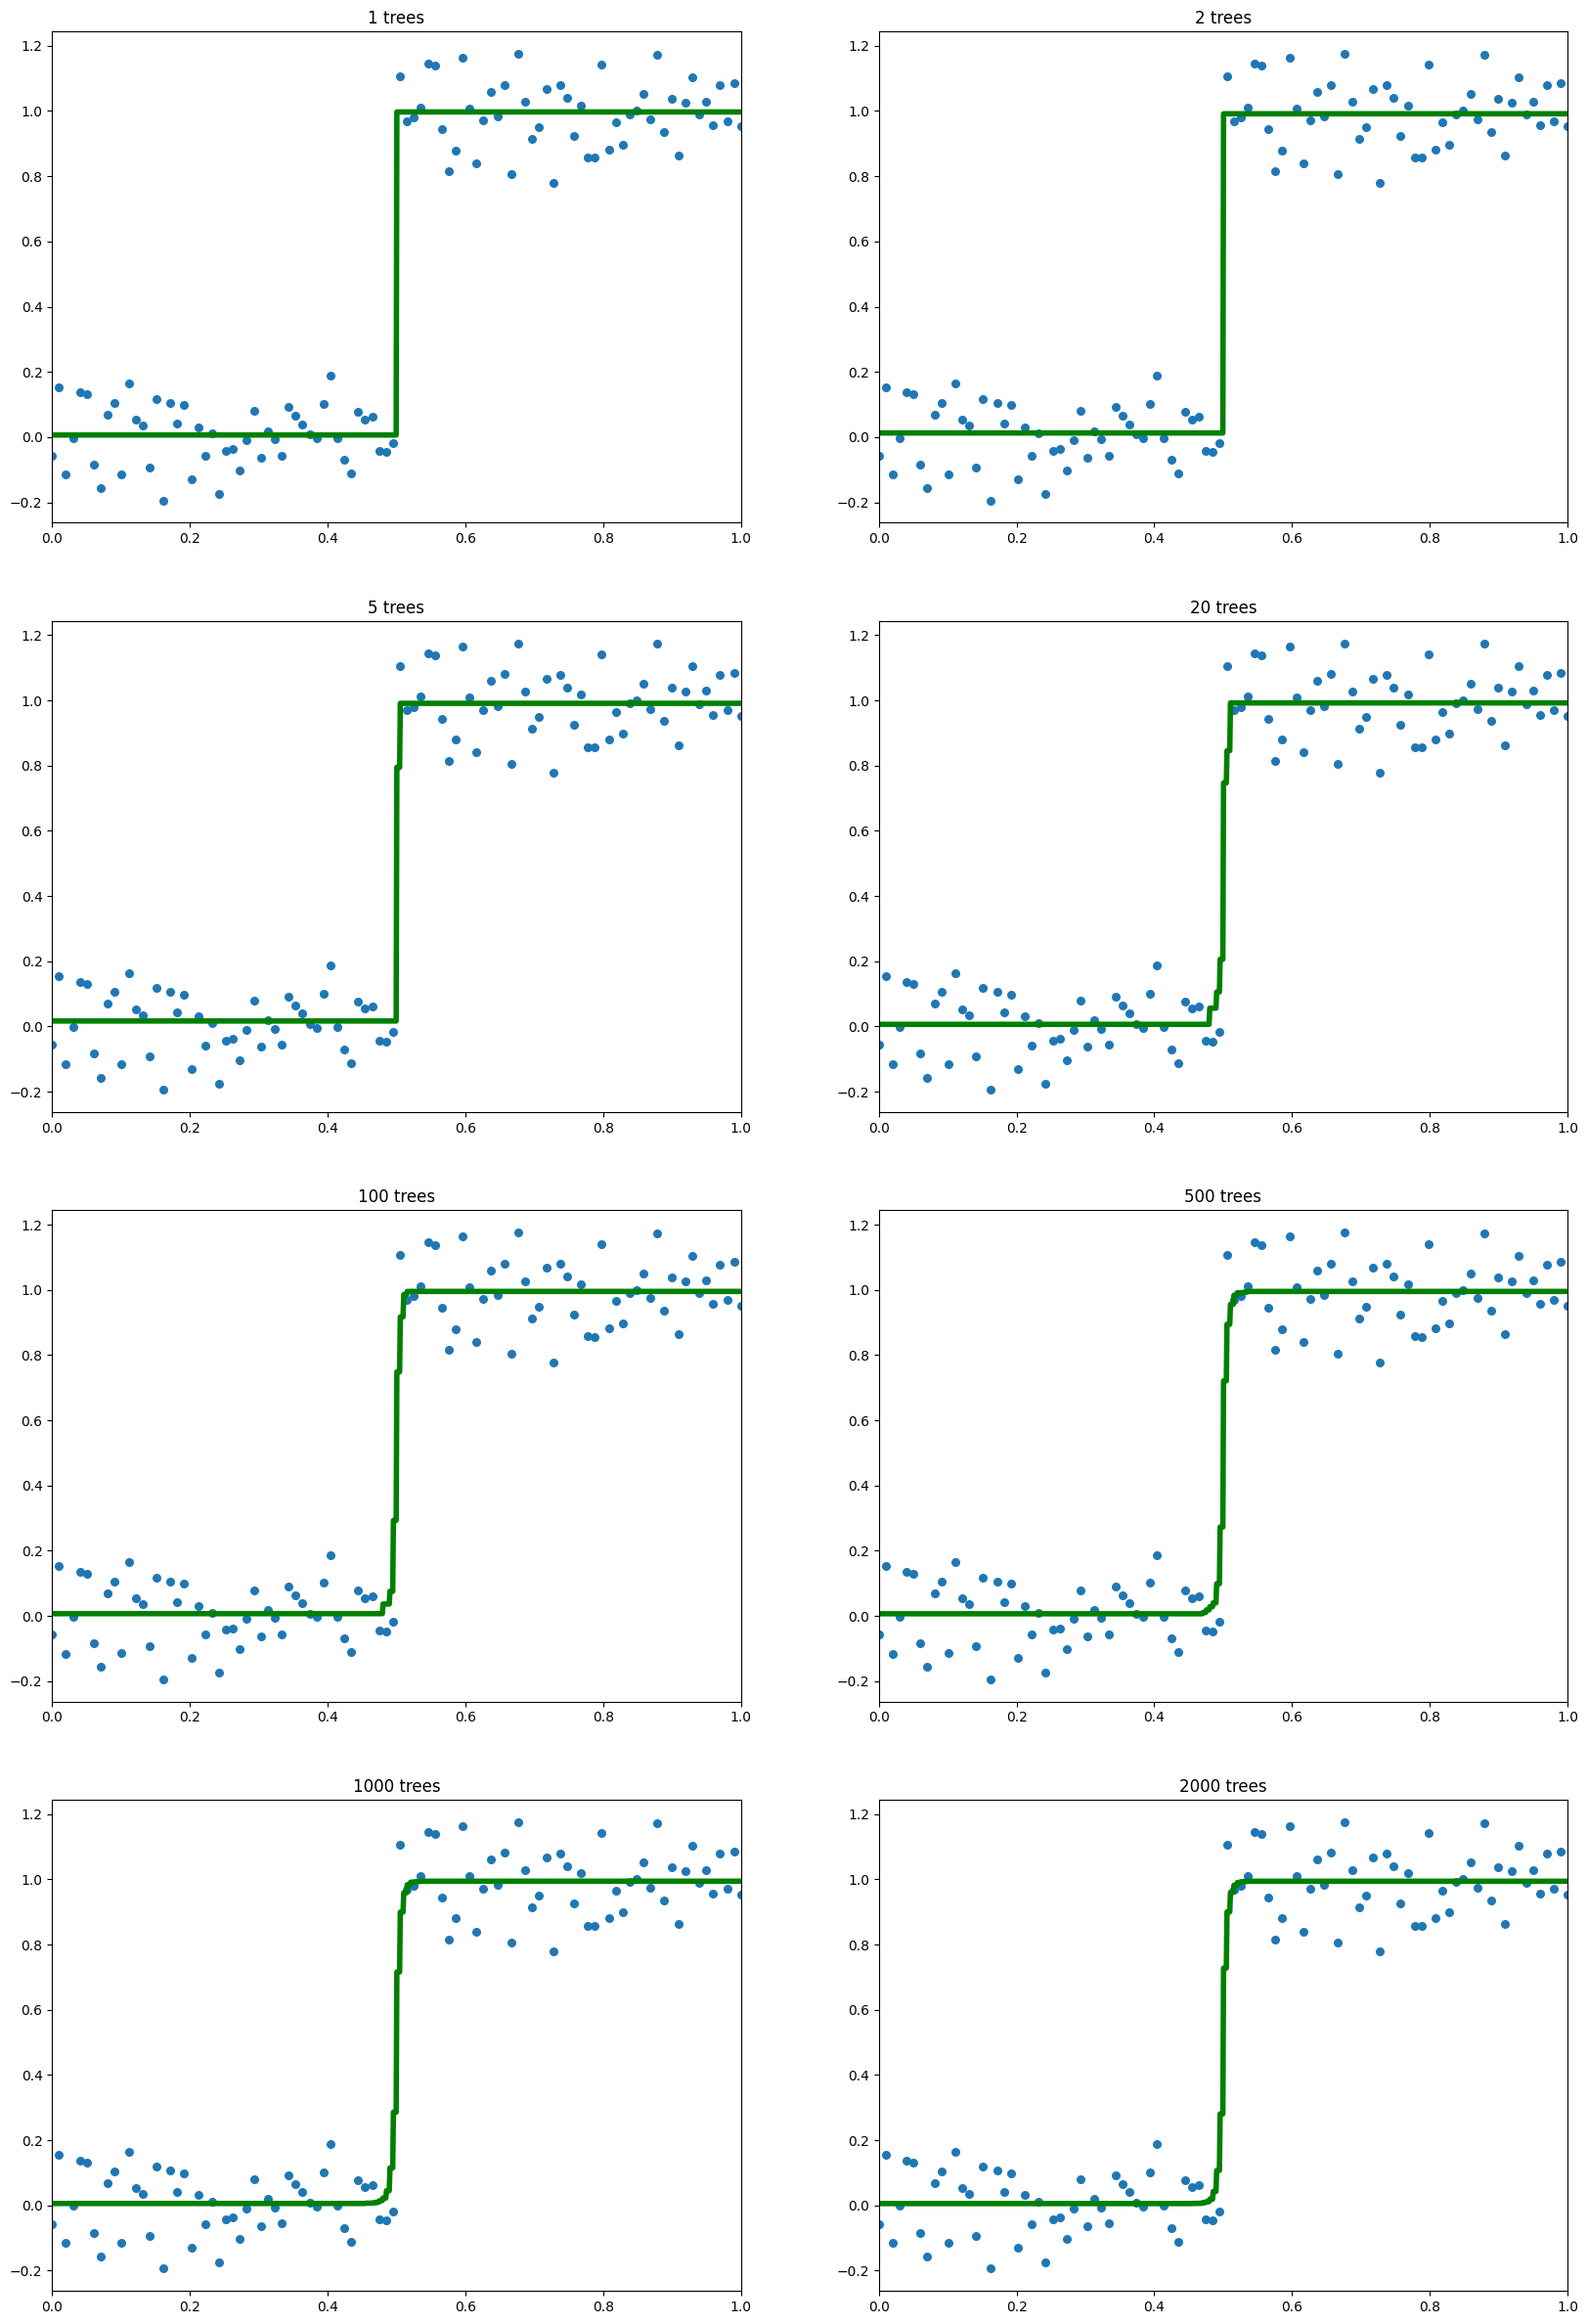

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=1), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

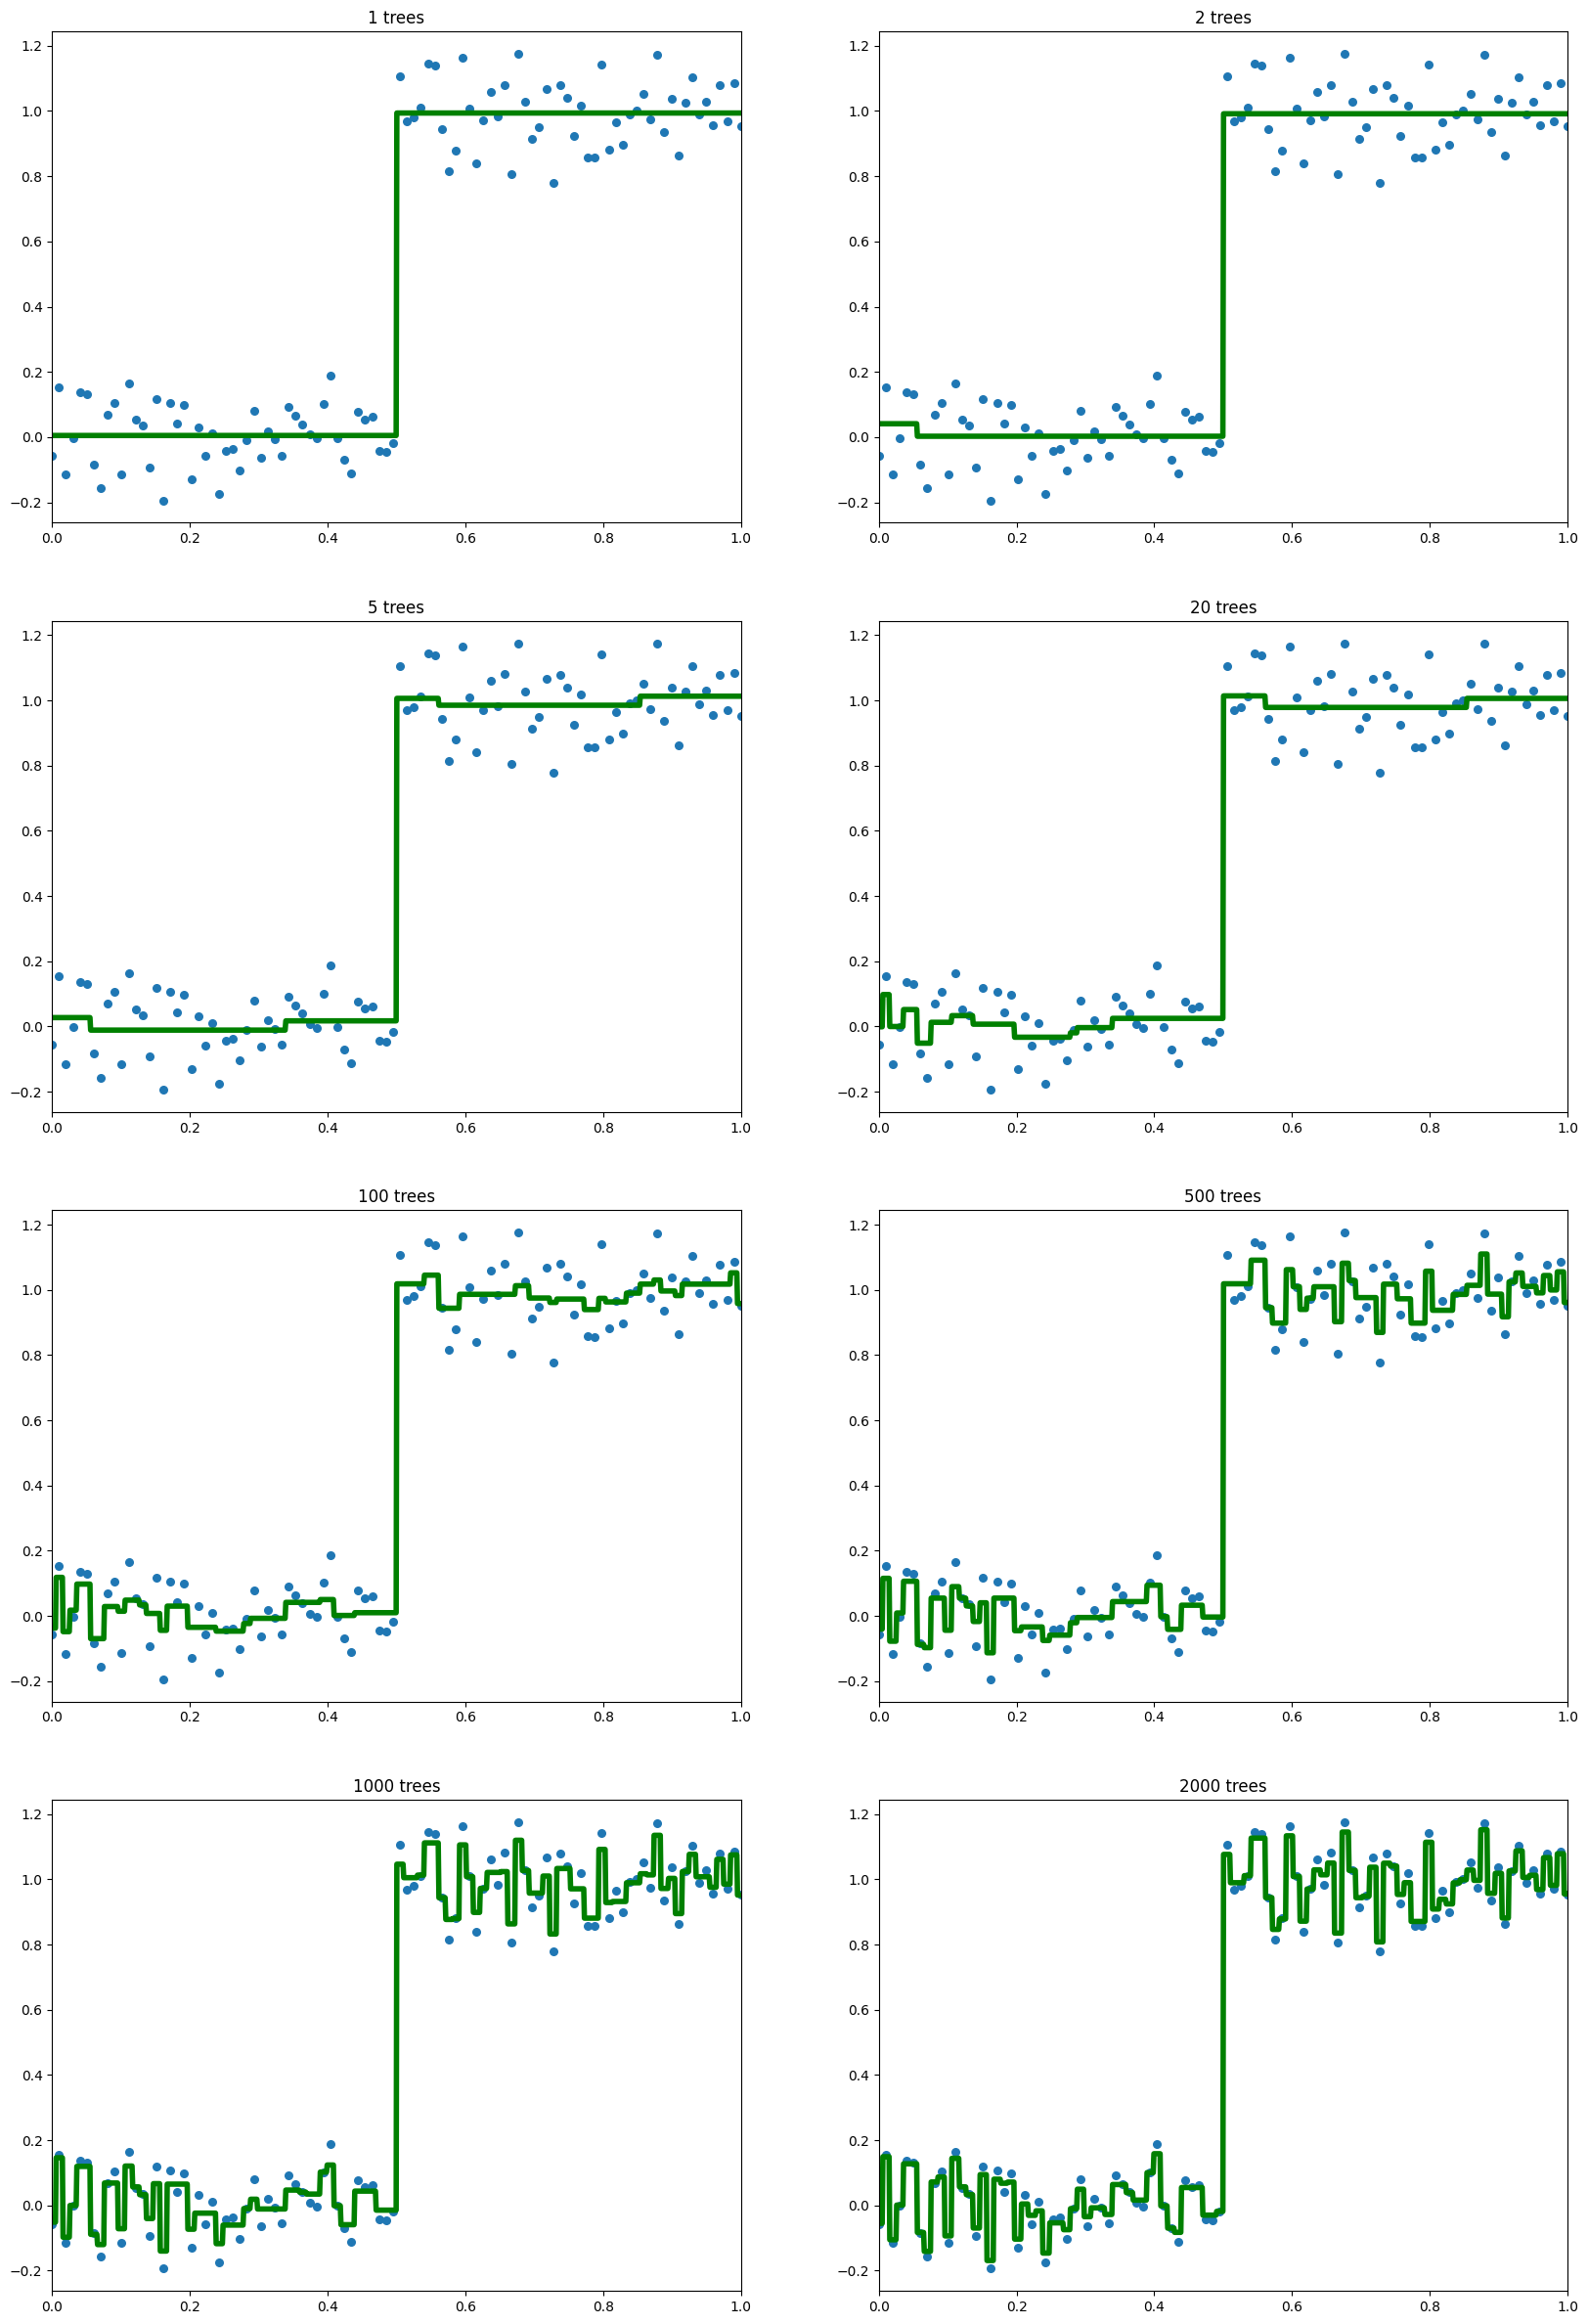

In [6]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

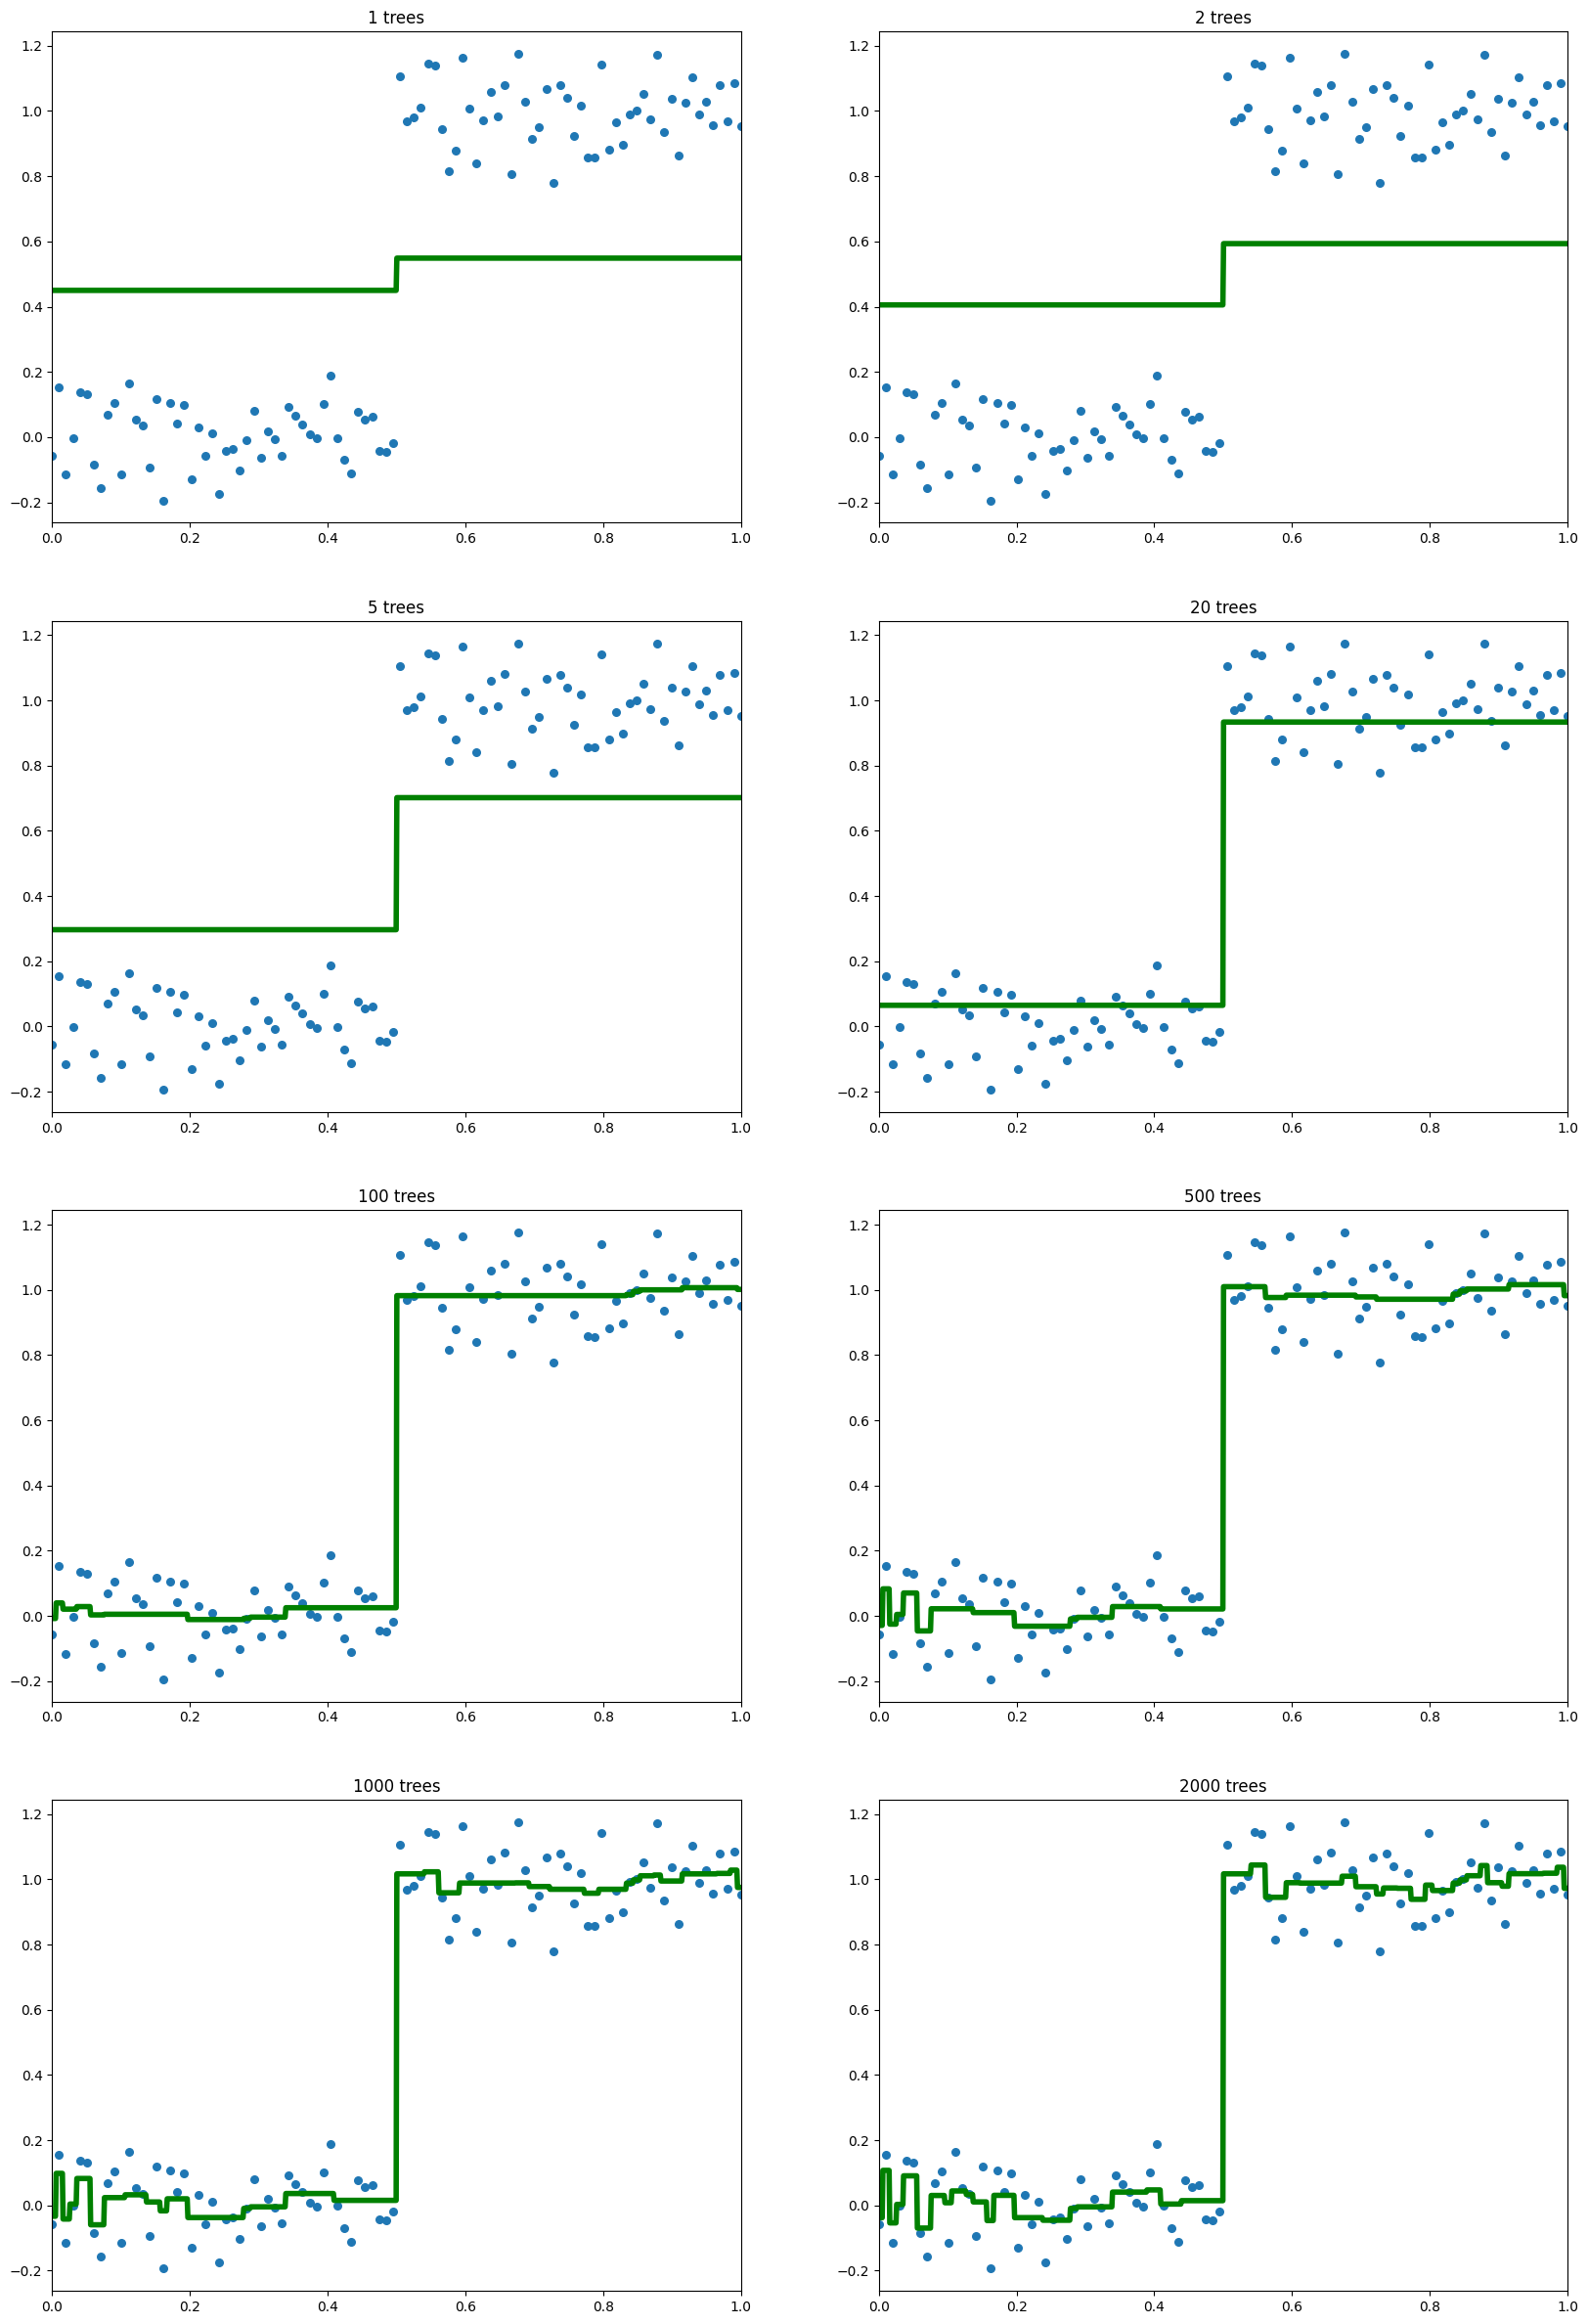

In [7]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Теперь проверим описанный выше эффект на реальных данных.

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5)

MAX_ESTIMATORS = 250

gbclf = GradientBoostingRegressor(warm_start=True)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

Text(0.5, 1.0, 'Test')

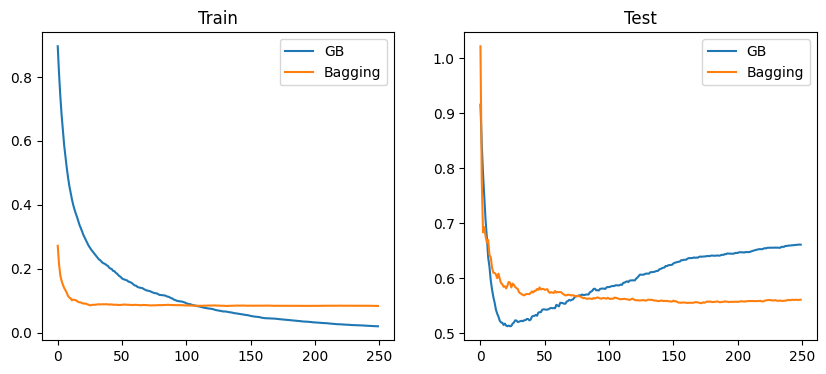

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')

## Градиентный бустинг и случайные леса

Как правило, в качестве композиции над некоррелированными решающими деревьями чаще рассматривают случайные леса, которые являются чуть усложнённой версией бэггинга над деревьями, а потому для них верны все приведенные ранее рассуждения.

**Задача 1.** Приведите временную асимптотику обучения и построения прогнозов для композиции вида $a_N(x) = \sum_{n=0}^N b_n(x)$ над решающими деревьями $b_n$.

**Решение.**
На стадии обучения при построении очередного решающего дерева глубины $D$ (под глубиной решающего дерева понимается максимальное количество ребер на кратчайшем пути от корня дерева до листа) нам необходимо выбрать предикаты в не более чем $2^D - 1$ внутренних вершинах этого дерева. Каждый порог выбирается путем перебора $\le l - 1$ значений  для каждого из $d$ признаков. После выбора предиктов необходимо вычислить прогноз дерева в каждом из листов за линейное время от количества объектов обучающей выборки, попавших в лист. Для вычисления прогнозов во всех листах одновременно нам достаточно один раз пройтись по всем объектам. Отсюда асимптотика построения одного решающего дерева — $O(2^D l d + l) = O(2^D l d).$

На стадии построения прогноза для объекта $x$ он "пропускается" через дерево от корня к листьям, тем самым проходя путь из не более чем $D$ внутренних вершин, в каждой из которых происходит проверка предиката за константное время. Отсюда имеем асимптотику для построения прогноза композиции — $O(ND)$.

Таким образом, вычислительно менее сложным оказывается процесс обучения большого количества неглубоких деревьев, а потому градиентный бустинг является более выгодным с точки зрения времени обучения алгоритмом по сравнению со случайным лесом.

Заметим также, что, поскольку обучение градиентного бустинга является "направленным", то ему требуется меньшее по сравнению со случайным лесом количество базовых алгоритмов для достижения того же качества композиции (на примере задачи [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse)):

In [12]:
!wget -O train.csv -q https://www.dropbox.com/s/8qfumwjto91jhs3/bio_train.csv

In [14]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


data = pd.read_csv('train.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X = data.values[:, 1:]
y = data.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [16]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           22.67s
         2           1.1722           19.84s
         3           1.1009           17.80s
         4           1.0528           16.69s
         5           1.0129           15.80s
         6           0.9739           15.15s
         7           0.9473           14.99s
         8           0.9194           14.58s
         9           0.9008           14.41s
        10           0.8814           14.28s
        20           0.7201           16.19s
        30           0.5950           15.25s
        40           0.5214           15.65s
        50           0.4482           14.33s
        60           0.3862           13.31s
        70           0.3427           12.26s
        80           0.3014           11.31s
        90           0.2723           10.51s
       100           0.2390            9.72s
       200           0.0787            3.02s
CPU times: user 13.7 s, sys: 311 ms, total: 14 s
Wall 

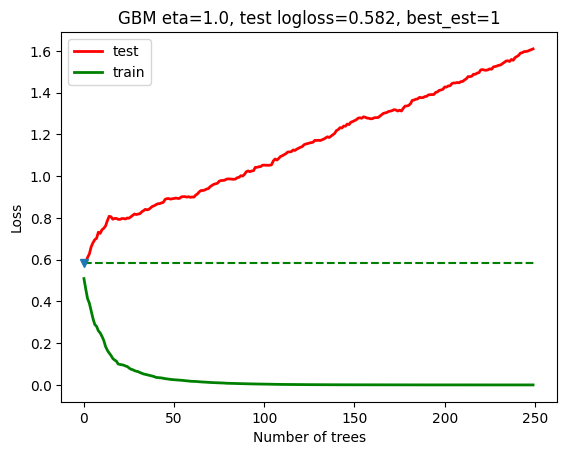

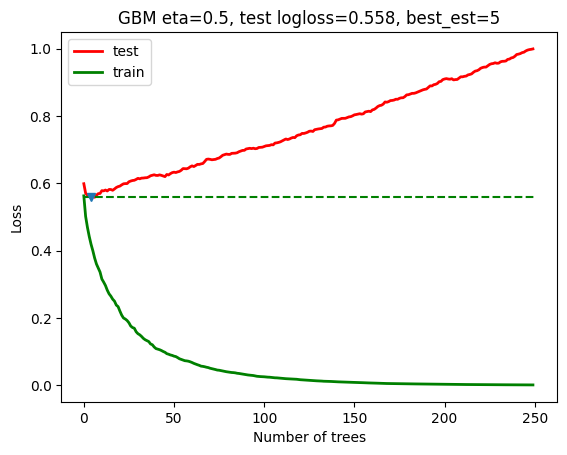

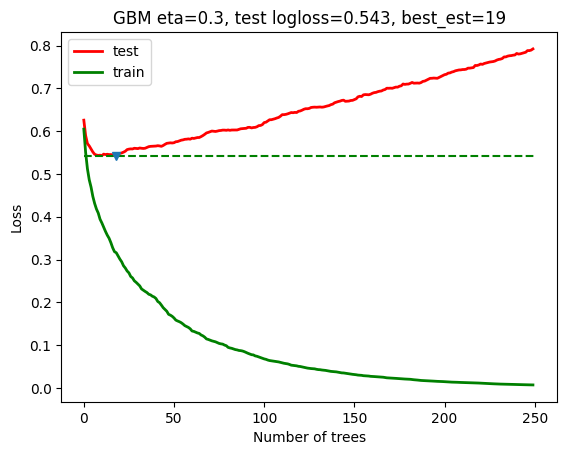

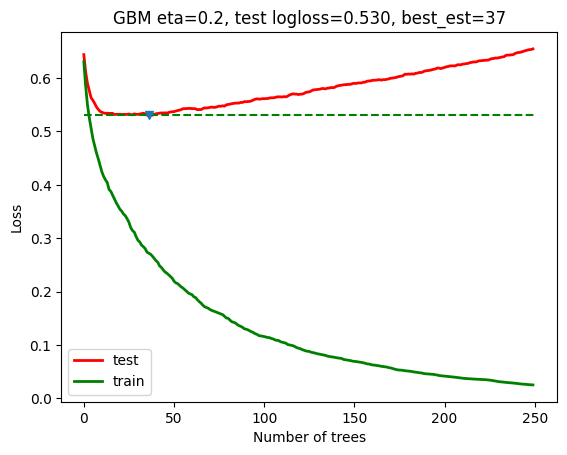

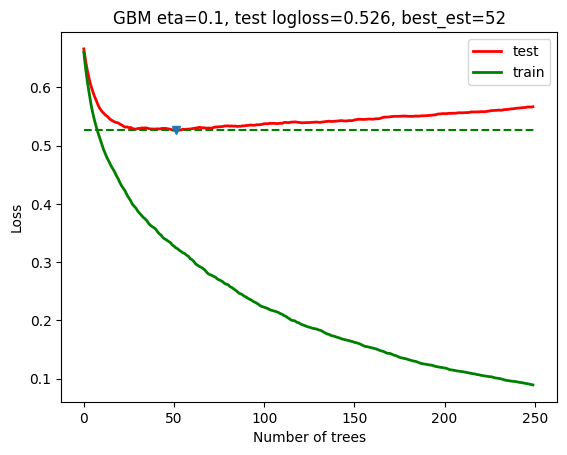

In [17]:
import numpy as np
from sklearn.metrics import log_loss

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = log_loss

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = l(y_test, y_pred)

    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = l(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    plt.plot([0, train_deviance.shape[0]], [test_deviance.min(), test_deviance.min()], 'g--')
    plt.plot([test_deviance.argmin()], [test_deviance.min()], 'v')
    plt.title('GBM eta=%.1f, test logloss=%.3f, best_est=%d' % (learning_rate, test_deviance.min(), test_deviance.argmin()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Loss')

Итого, лучшая композиция построена при $\eta = 0.1$, включает 52 базовых алгоритма и достигает значения 0.526 на контрольной выборке. При этом случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу:

In [18]:
rf = RandomForestClassifier(n_estimators=52, random_state=241).fit(X_train, y_train)
print('Train RF log-loss =', log_loss(y_train, rf.predict_proba(X_train)))
print('Test RF log-loss = ', log_loss(y_test, rf.predict_proba(X_test)))

Train RF log-loss = 0.15668813888965608
Test RF log-loss =  0.5383402553854034


Заметим также, что при всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, требующие вычислительных мощностей для их обучения.

Для достижения такого же качества случайному лесу требуется гораздо большее число базовых алгоритмов:

In [19]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print(n_estimators, 'trees: train log-loss =', log_loss(y_train, rf.predict_proba(X_train)), 'test log-loss =', log_loss(y_test, rf.predict_proba(X_test)))

10 trees: train log-loss = 0.16082728888806366 test log-loss = 0.7349533875993263
20 trees: train log-loss = 0.15882532494149082 test log-loss = 0.5945750972019007
30 trees: train log-loss = 0.15792979149316982 test log-loss = 0.5569388873372119
40 trees: train log-loss = 0.15337494423797157 test log-loss = 0.5348693136225132
50 trees: train log-loss = 0.157795263849364 test log-loss = 0.5322022410189035
60 trees: train log-loss = 0.1524757597534505 test log-loss = 0.5288548760785375
70 trees: train log-loss = 0.15224151485798443 test log-loss = 0.5185457181758467
80 trees: train log-loss = 0.15739719874268995 test log-loss = 0.5262550061736597
90 trees: train log-loss = 0.1547962768888309 test log-loss = 0.5227302043719542
100 trees: train log-loss = 0.15627519425422295 test log-loss = 0.5309597154632988


## Свойства градиентного бустинга над решающими деревьями

**Задача 2.** Пусть решается задача регрессии на одномерной выборке $X = \{ (x_i, y_i)\}_{i=1}^l,$ при этом истинная зависимость целевой переменной является линейной: $y(x) = ax + \varepsilon, \, \varepsilon \sim p(\varepsilon) = \mathcal{N} (0, \sigma^2).$ Допустим, не зная этого, вы обучили на выборке линейную регрессию и решающее дерево с функционалом MSE, и вам известно, что модели не переобучились. После этого вы получили новые данные и построили на них прогнозы обеих моделей, и оказалось, что для решающего дерева значение функционала ошибки на новых данных оказалось радикально выше, чем для линейной регрессии. Чем это может быть вызвано?

**Решение.**
Поскольку истинная зависимость в данных является линейной, логично предположить, что линейная модель покажет лучшие результаты на подобной выборке. Опишем формально ситуацию, в которой у решающего дерева могут возникнуть серьезные проблемы с восстановлением истинной зависимости.

Допустим, обучающая выборка была получена из отрезка $[0; 10],$ обучим соответствующие модели и построим прогнозы для этого отрезка:

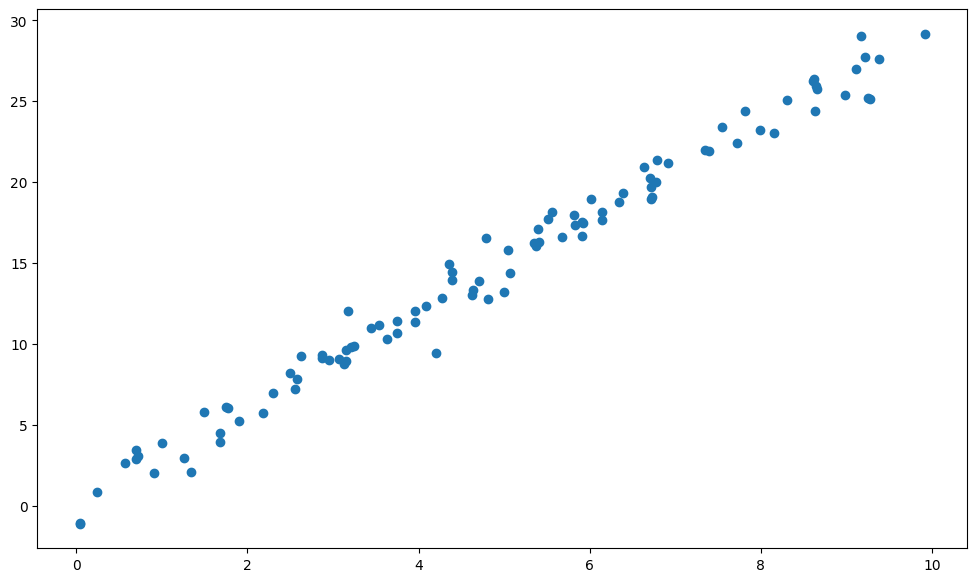

In [20]:
from numpy.random import rand, randn

set_size = 100
lin_coef = 3
sigma = 1

X_train = (rand(set_size) * 10).reshape(-1, 1)
Y_train = X_train * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, Y_train)
tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)

DecisionTreeRegressor()

LR train MSE =  0.9499363710226764
DT train MSE =  0.0


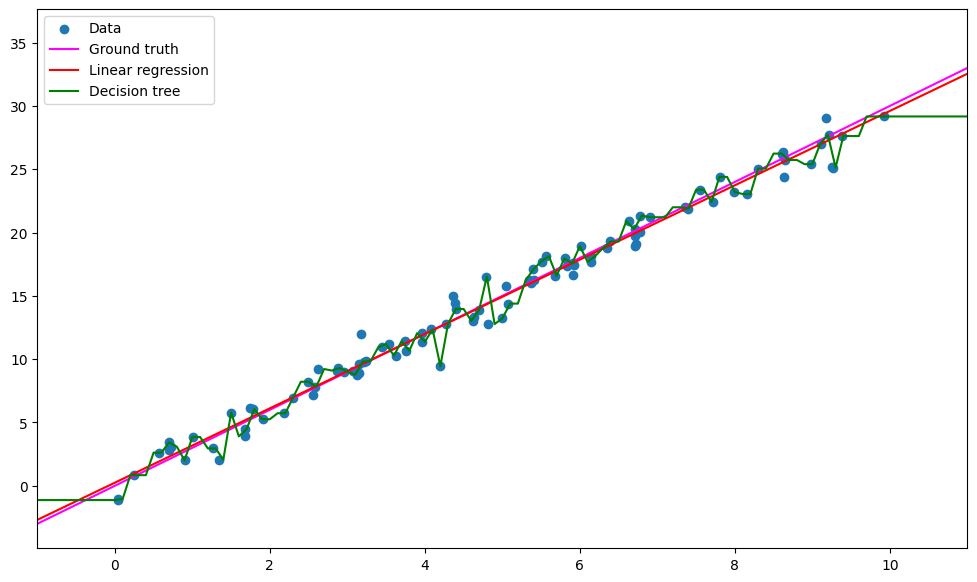

In [22]:
from numpy.random import rand, randn

grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 11])
plt.legend(['Data', 'Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print('LR train MSE = ', mean_squared_error(Y_train, lr.predict(X_train)))
print('DT train MSE = ', mean_squared_error(Y_train, tree.predict(X_train)))

Предположим, что новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30].$ В этом случае предсказания линейной регрессии окажутся гораздо ближе к правде, что отразится и на значении функционала ошибки:

LR test MSE =  1.3903213706377184
DT test MSE =  2223.6549138456767


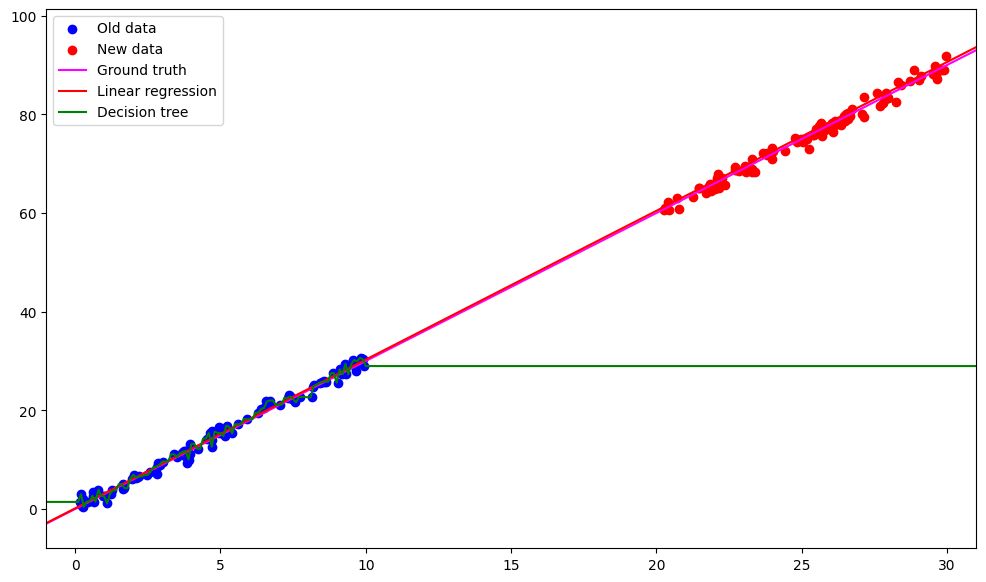

In [22]:
from numpy.random import rand, randn

grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

X_test = (20 + rand(set_size) * 10).reshape(-1, 1)
Y_test = X_test * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train, c='blue')
plt.scatter(X_test, Y_test, c='red')

plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 31])
plt.legend(['Old data', 'New data', 'Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print('LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test)))
print('DT test MSE = ', mean_squared_error(Y_test, tree.predict(X_test)))

**Вывод**: решающие деревья (а потому и композиции над ними, в т.ч. градиентный бустинг) непригодны для экстраполяции функций.

В качестве решения этой проблемы в некоторых случаях можно использовать [нормализацию](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization).

**Задача 3.** Пусть решается задача регрессии для двумерной выборки $X = \{ (x_i, y_i) \}_{i=1}^l,$ при этом истинная зависимость целевой переменной $y(x) = y((x_1, x_2)) = sgn ((x_1 - 40)x_2).$ Предположим, вы обучили на выборке $X$ решающие деревья глубины 1, 2 и 3. Как соотносятся значения функционала $MSE$ для каждой из этих моделей? Почему? Какие зависимости позволяют улавливать глубокие деревья по сравнению с неглубокими?

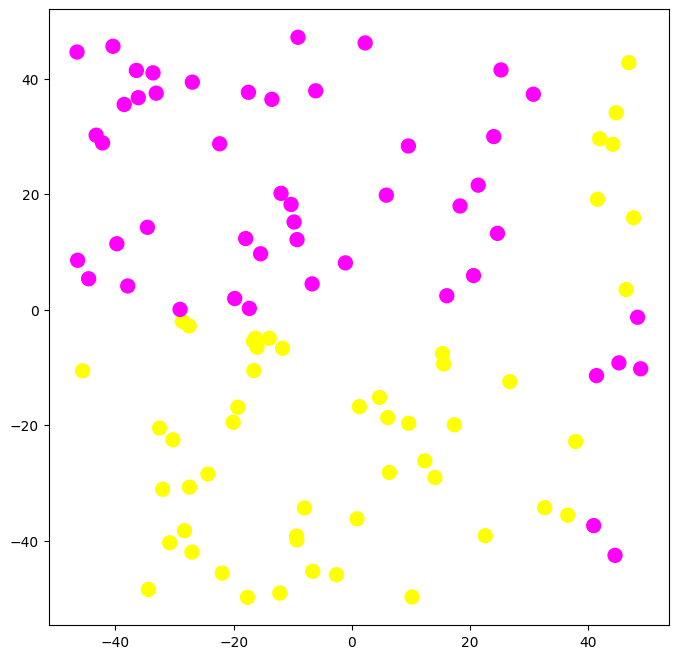

In [23]:
X = -50 + 100 * np.random.rand(100, 2)
Y = np.sign((X[:, 0] - 40) * X[:, 1])
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, cmap='spring')

DT MSE (max_depth = 1) =  0.4208
DT MSE (max_depth = 2) =  0.035
DT MSE (max_depth = 3) =  0.0


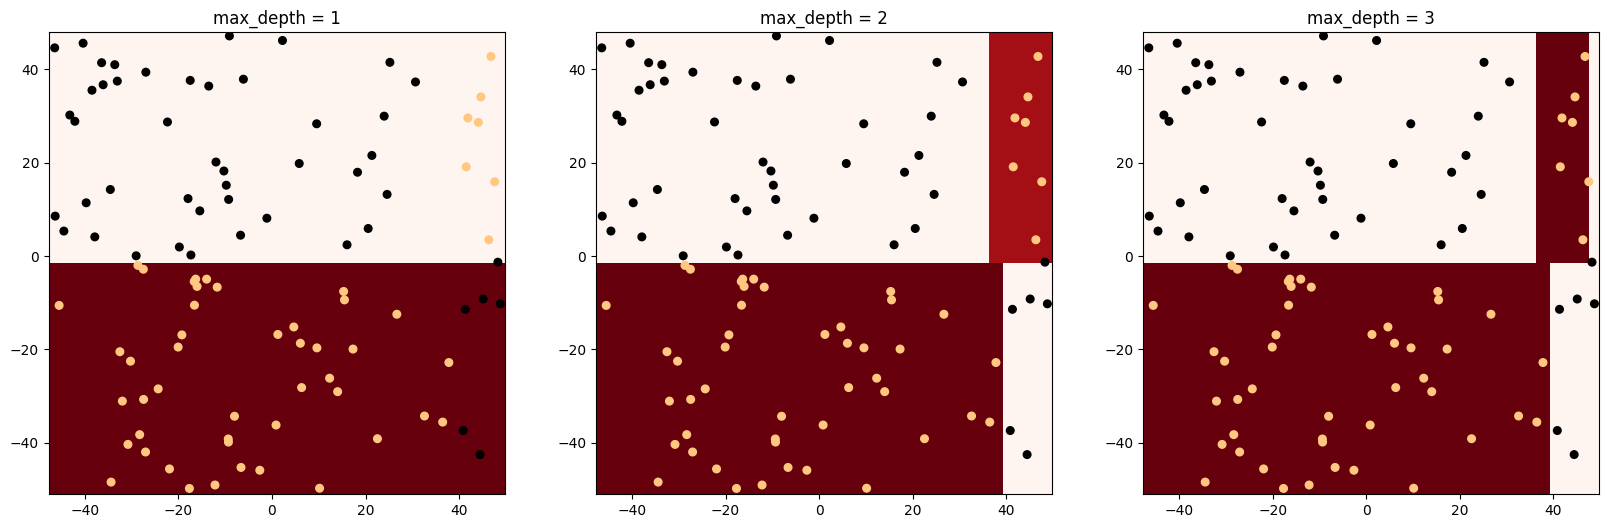

In [24]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.5),
                         np.arange(y_min, y_max, 0.5))
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42, max_depth = i + 1)

    clf.fit(X, Y)
    xx, yy = get_grid(X)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='Reds')
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap='copper')
    plt.title('max_depth = ' + str(i + 1))
    print('DT MSE (max_depth = ' + str(i+1) + ') = ', mean_squared_error(Y.reshape(-1, 1), clf.predict(X)))

Можно видеть, что с незначительным ростом глубины дерева ошибка на данных стремительно падает. Это связано с тем, что истинная зависимость целевой переменной учитывает взаимодействия признаков, а потому дерево глубины 1 в любом случае не может восстановить подобную зависимость, поскольку учитывается лишь один из признаков; дерево глубины 2 позволяет учесть взаимодействие пар признаков и т.д.

**Вывод**: если вам известно, что в задаче необходимо учитывать взаимодействие $N$ признаков, корректным решением будет ограничивать глубину деревьев в градиентном бустинге числом, большим $N$. Кроме того, если вам из некоторых экспертных знаний известно, что на целевую переменную оказывает влияние конкретное взаимодействие различных признаков, следует добавить его явно в качестве признака, поскольку это может позволить повысить качество.

[Визуализация](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) градиентного бустинга для решающих деревьев различной глубины для функций различного вида.

**Задача 4.** Пусть дана некоторая выборка $X = \{ (x_i, y_i)\}_{i=1}^l.$ Как изменится решающее дерево, обученное на этой выборке, при масштабировании признаков?

**Решение.** Рассмотрим некоторую вершину $m$ и множество $R_m$ объектов, попавших в неё. Заметим, что значение целевой переменной при масштабировании не изменится, а потом значение критерия информативности для каждого из возможных разбиений останется тем же самым (изменятся лишь значения порогов для каждого из признаков). В связи с этим в вершине $m$ в качестве оптимального будет выбрано то же разбиение, что и раньше. Поскольку это верно для любой вершины, построенное решающее дерево не изменится.

Данные рассуждения также верны для любого монотонного преобразования признаков.

### Размер шага в градиентном бустинге

Напомним, что в качестве меры для борьбы с переобучением в градиентном бустинге используют размер шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_n b_n(x).$$

Исследуем зависимость скорости сходимости градиентного бустинга в зависимости от размера шага и богатства семейства базовых алгоритмов $\mathcal{B}$. На каждом шаге мы выбираем новый базовый алгоритм из семейства, обучая его на векторе сдвигов. Тем не менее, не всегда получается найти алгоритм, идеально приближающие посчитанный вектор сдвигов, поэтому иногда добавление нового базового алгоритма может "увести" нас в сторону.

Рассмотрим обычный градиентный спуск и смоделируем описанную ситуацию, используя не честно посчитанный антиградиент, а его зашумленный вариант, и исследуем, за какое количество шагов (сколько базовых алгоритмов потребуется бустингу) мы сможем оказаться в окрестности оптимума в зависимости от длины шага:

In [25]:
def fun(x, y):
    return x**2 + 2 * y ** 2
   
def grad(x, y):
    return np.array([2 * x, 4 * y])

def make_data():
    x = np.arange (-100, 100, 0.1)
    y = np.arange (-100, 100, 0.1)
    xgrid, ygrid = np.meshgrid(x, y)
    zgrid = fun(xgrid, ygrid)
#    zgrid = np.sin (xgrid) * np.sin (ygrid) / (xgrid * ygrid)
    return xgrid, ygrid, zgrid


def gradient_descent(numIterations, eta, noise):
    ans = np.array([-70, 80])
    x_points = [ans[0]]
    y_points = [ans[1]]
    for iter in range(0, numIterations):
        ans = ans - eta * (grad(ans[0], ans[1]) + noise * np.random.randn(2))
        x_points.append(ans[0])
        y_points.append(ans[1])
    return (x_points, y_points)

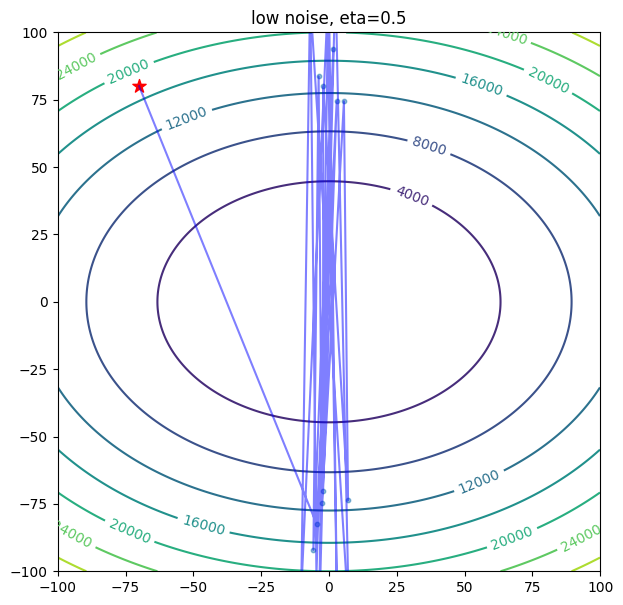

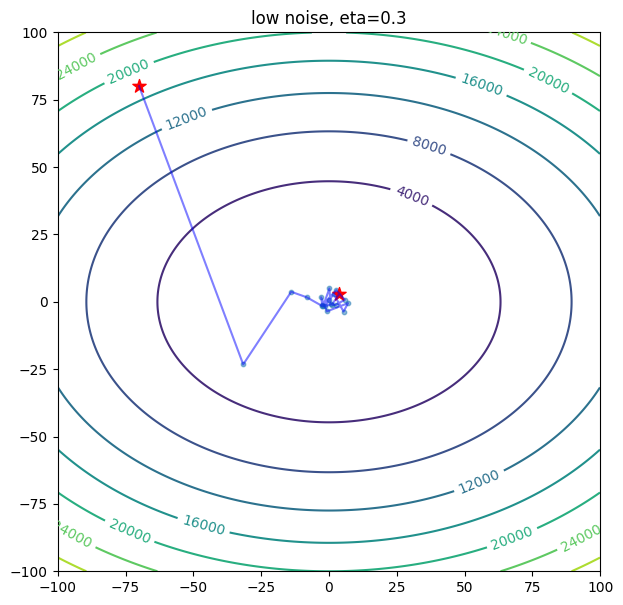

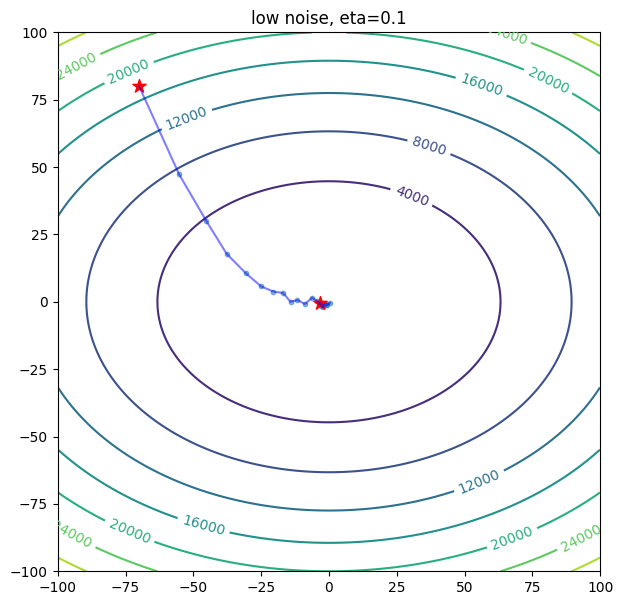

In [26]:
import numpy as np
from sklearn.metrics import log_loss
X, Y, Z = make_data()

for learning_rate in [0.5, 0.3, 0.1]:
    x_points, y_points = gradient_descent(20, learning_rate, 10)
    plt.figure(figsize = (7, 7))
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(x_points, y_points, linestyle = '-', color = 'blue', alpha = 0.5)
    plt.scatter(x_points[1:-1], y_points[1:-1], marker = '.', s=40, alpha = 0.5)
    plt.scatter([x_points[0], x_points[-1]], [y_points[0], y_points[-1]], 
                marker = '*', s=100, color = 'red')
    
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.title('low noise, eta=%.1f' % learning_rate)

Если семейство алгоритмов $\mathcal{B}$ более бедное, то направление движение на каждом шаге будет сильнее отличаться от антиградиента:

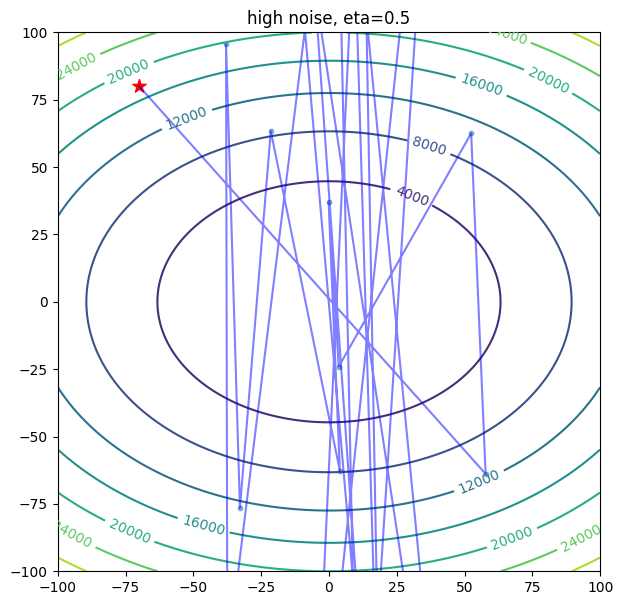

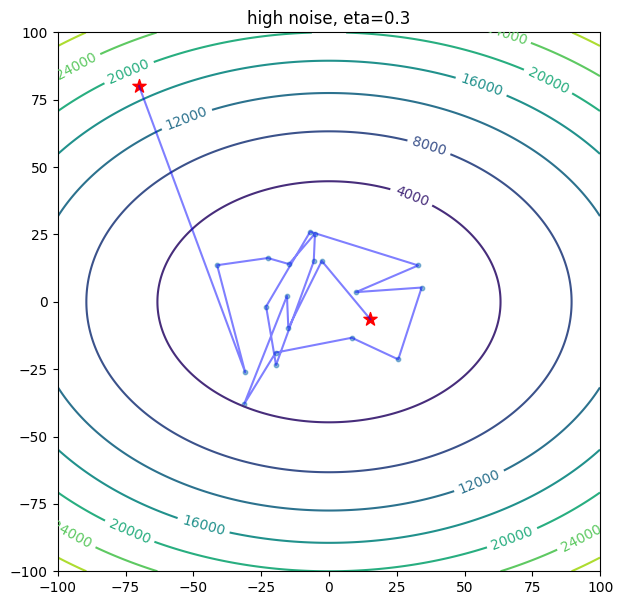

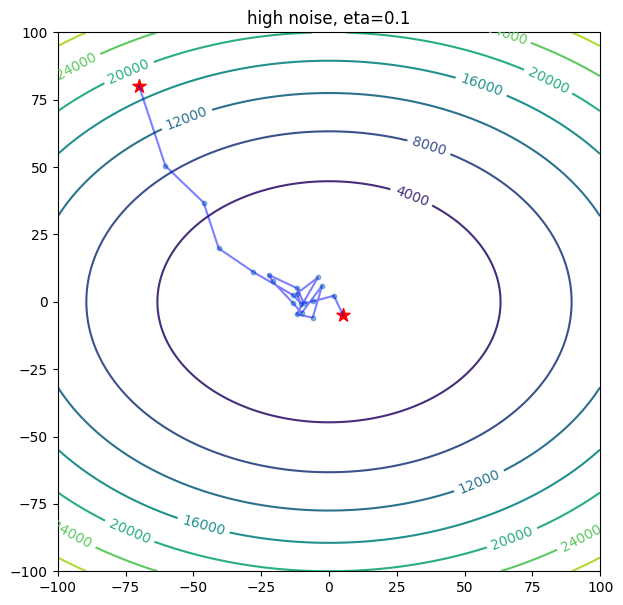

In [27]:
import numpy as np
from sklearn.metrics import log_loss
X, Y, Z = make_data()

for learning_rate in [0.5, 0.3, 0.1]:
    x_points, y_points = gradient_descent(20, learning_rate, 50)
    plt.figure(figsize = (7, 7))
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(x_points, y_points, linestyle = '-', color = 'blue', alpha = 0.5)
    plt.scatter(x_points[1:-1], y_points[1:-1], marker = '.', s=40, alpha = 0.5)
    plt.scatter([x_points[0], x_points[-1]], [y_points[0], y_points[-1]], 
                marker = '*', s=100, color = 'red')
    
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.title('high noise, eta=%.1f' % learning_rate)

Можно видеть, что с уменьшением размера шага градиентному бустингу требуется больше базовых алгоритмов для достижения приемлемого качества композиции, однако при этом сходимость такого процесса надежнее.

## XGBoost

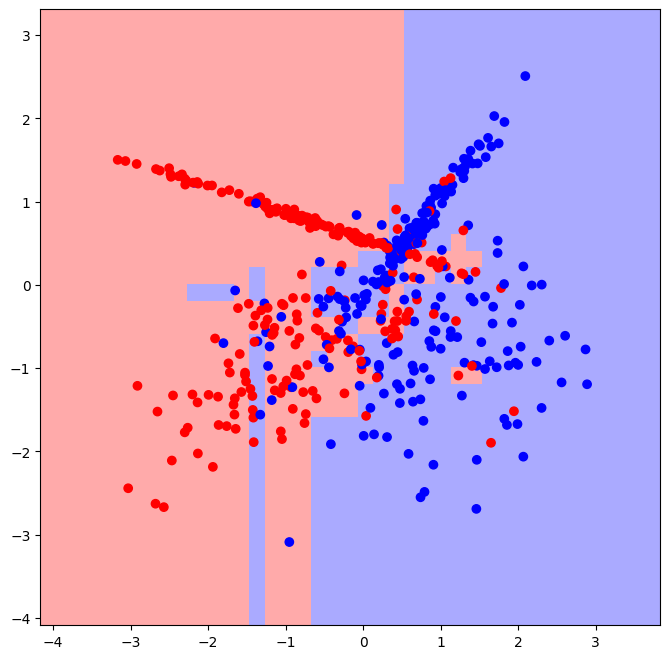

In [32]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
import xgboost as xgb

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
clf = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01)
clf.fit(X, y)
plot_surface(X, y, clf)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

0.8806009957325747


In [34]:
?xgb.XGBClassifier

Init signature:
xgb.XGBClassifier(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : Optional[int]
        Number of boosting rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of ve

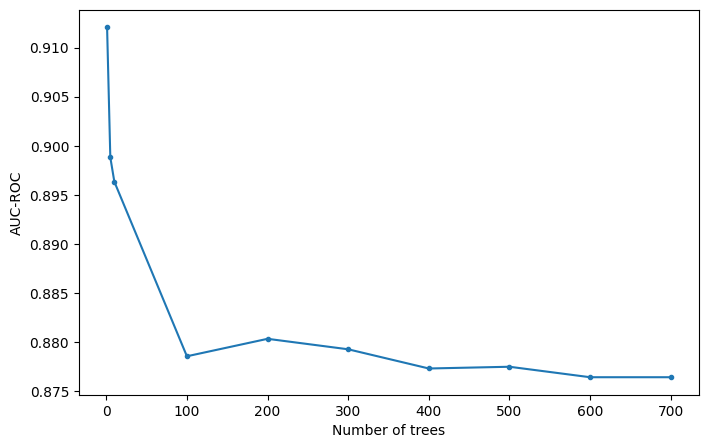

In [35]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = xgb.XGBClassifier(n_estimators=n, max_depth=6, learning_rate=0.5)
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()


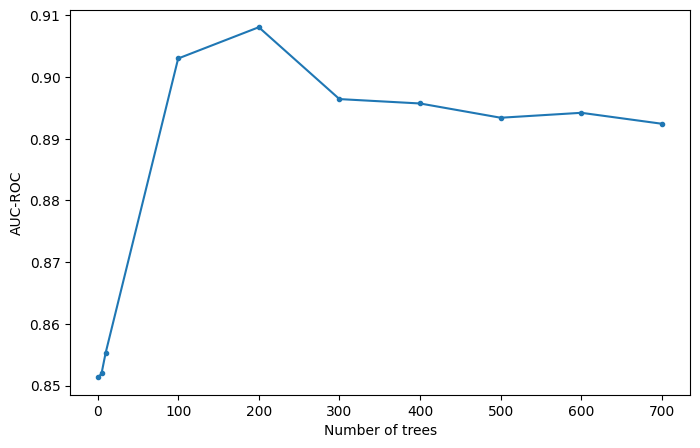

In [36]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = xgb.XGBClassifier(n_estimators=n, max_depth=2, learning_rate=0.03)
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()



In [38]:
from lightgbm import LGBMClassifier
from catboost import CatboostClassifier

OSError: dlopen(/Users/user04/DataspellProjects/hse_programming_and_computer_sciences/venv/lib/python3.11/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <C3EB28DD-60B6-3334-AFA2-72BBBF9DBAEF> /Users/user04/DataspellProjects/hse_programming_and_computer_sciences/venv/lib/python3.11/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

[Сравнение XGBoost, CatBoost и LGBM](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm)